In [1]:
import sys
sys.path.append('../src')

from module.module import Linear, Conv1D, MaxPool1D, Flatten
from module.activation import TanH, Sigmoide, ReLU

from loss.loss import CrossEntropie, CELogSoftmax
from networks.optim import Optim
from networks.sequentiel import Sequentiel

from utils.processing import one_hot_y
from utils.plots import plot_net, classification_report

import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

from resizeimage import resizeimage
from scipy.ndimage import rotate

import os
from PIL import Image

In [2]:
def rotate_image(img, angle):
    return rotate(img, angle, reshape=False, cval=255)

In [3]:
def get_signatures(test=False):
    
    type_data = "Train"
    if test:
        type_data = "Test"
        
    folder_dir = f"../data/signature/{type_data}"
    
    X = []
    y = []
    
    new_size = (28, 28)
    
    i = 0
    for person in os.listdir(folder_dir):
        
        for path in os.listdir(f"{folder_dir}/{person}"):
            img = Image.open(f"{folder_dir}/{person}/{path}")
            img = np.array(resizeimage.resize_contain(img, [75, 75]))[:,:,0:3].reshape(-1, 3)
            
            X.append(img)
            y.append(i)
            
            img_r = rotate_image(img.reshape(75, 75, 3), 90).reshape(-1, 3)
            X.append(img_r)
            y.append(i)
        
            img_r = rotate_image(img.reshape(75, 75, 3), 180).reshape(-1, 3)
            X.append(img_r)
            y.append(i)
            
            img_r = rotate_image(img.reshape(75, 75, 3), 270).reshape(-1, 3)
            X.append(img_r)
            y.append(i)
            
            img_r = rotate_image(img.reshape(75, 75, 3), 45).reshape(-1, 3)
            X.append(img_r)
            y.append(i)
            
            img_r = rotate_image(img.reshape(75, 75, 3), 135).reshape(-1, 3)
            X.append(img_r)
            y.append(i)
            
            img_r = rotate_image(img.reshape(75, 75, 3), 225).reshape(-1, 3)
            X.append(img_r)
            y.append(i)
            
            img_r = rotate_image(img.reshape(75, 75, 3), 315).reshape(-1, 3)
            X.append(img_r)
            y.append(i)
            
        i += 1

    X = np.array(X)
    y = np.array(y)
    
    indices = np.random.permutation(len(X))
    return X[indices], y[indices]

In [4]:
X_train, y_train = get_signatures()

X_train = (X_train - X_train.min(axis=1, keepdims=True)) / (X_train.max(axis=1, keepdims=True) - X_train.min(axis=1, keepdims=True))

In [5]:
X_train.shape

(1600, 5625, 3)

In [6]:
X_test, y_test = get_signatures(test=True)

In [7]:
classes = len(np.unique(y_train))

In [8]:
y_one_hot = one_hot_y(y_train, classes)

In [9]:
X_conv = X_train
X_conv.shape

(1600, 5625, 3)

100%|██████████| 150/150 [29:38<00:00, 11.85s/it]


Training completed.


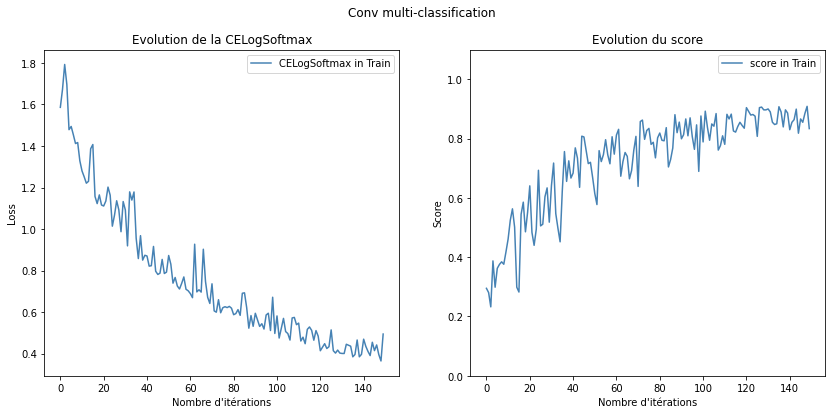

In [10]:
np.random.seed(42)

net = Sequentiel([
    Conv1D(k_size=2, chan_in=3, chan_out=16, stride=3, init="xavier"),
    MaxPool1D(2, 3), 
    Flatten(),
    Linear(10_000, 100, init="xavier"),
    ReLU(),
    Linear(100, 5, init="xavier"),
], classes_type="multi")

optim = Optim(net, CELogSoftmax(), eps=1e-5)
optim.SGD(X_conv, y_one_hot, test_train_split=False, batch_size=30, epochs=150, verbose=False)

plot_net(optim, X_conv, y_one_hot, net_type="multiclass", net_title="Conv multi-classification")

In [13]:
net.score(X_test, y_test)

0.775

In [20]:
yhat = net.predict(X_test).reshape(-1)

In [21]:
yhat.shape

(320,)

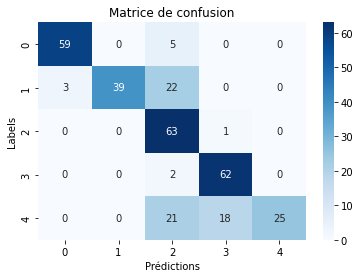

In [22]:
df = classification_report(y_test, yhat, [f"{i}" for i in range(5)])

In [23]:
print(df.to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrllr}
\toprule
{} &  precision & recall & f1-score &  support \\
class    &            &        &          &          \\
\midrule
0        &       0.95 &   0.92 &     0.94 &       64 \\
1        &       1.00 &   0.61 &     0.76 &       64 \\
2        &       0.56 &   0.98 &     0.71 &       64 \\
3        &       0.77 &   0.97 &     0.86 &       64 \\
4        &       1.00 &   0.39 &     0.56 &       64 \\
accuracy &       0.78 &        &          &      320 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_34485/2413356786.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(float_format="{:.2f}".format))
